# Introduction to functional data cleaning using nilearn

### Movement is the enemy of neuroimagers

In task-based fMRI, if participants move during task-relevant moments
- Get a huge **false task-related signal** that’s actually due to motion!

In resting-state fMRI, movement can induce **false correlations** between brain regions


Solving for this involves *modelling* our fMRI signal to be comprised of **true brain signal** and **confounder signals**. 


Our goal is to remove a majority (hopefully) of the **confounder signals** and acquire something *closer* to the **true signal**. 

This is achieved via **confound regression**, which is essentially fitting a linear model using confounds as regressors then subtracting it out from the signal


*****

In [2]:
import os
from nilearn import image as nimg
from nilearn import plotting as nplot
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import bids
%matplotlib inline

## Step 1: Implementing Confound Regression using FMRIPREP outputs
FMRIPREP estimates confounds for the functional image and outputs it into:

**sub-xxxxx_task-xxxx_space-xxxx_..._desc-confounds_regressors.tsv**

Let's load one up and see what it looks like

In [4]:
sub = '10788'
fmriprep_dir = '../data/ds000030/derivatives/fmriprep/'
layout = bids.BIDSLayout(fmriprep_dir,validate=False,
                        config=['bids','derivatives'])

In [25]:
func_files = layout.get(subject=sub,
                        datatype='func', task='rest',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz')

mask_files = layout.get(subject=sub,
                        datatype='func', task='rest',
                        desc='brain',
                        suffix='mask',
                        space='MNI152NLin2009cAsym',
                        extension="nii.gz")

confound_files = layout.get(subject=sub,
                            datatype='func', task='rest',
                            desc='confounds',
                           extension="tsv")

In [26]:
func_file = func_files[0].path
mask_file = mask_files[0].path
confound_file = confound_files[0].path

The confounds file is organized like an excel spread-sheet with multiple columns, each for a specific confound.

We can view these using pandas 

In [27]:
import pandas as pd

In [47]:
confound_df = pd.read_csv(confound_file,delimiter='\t')
mask = os.path.join(mask_file) 

In [48]:
confound_df.head()

,global_signal,global_signal_derivative1,global_signal_derivative1_power2,global_signal_power2,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,...,rot_y_power2,rot_z,rot_z_derivative1,rot_z_power2,rot_z_derivative1_power2,motion_outlier00,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04
0,637.338734,NaN,NaN,406200.661813,739.137476,NaN,NaN,546324.207951,690.585770,NaN,...,0.000001,0.000333,NaN,1.106440e-07,NaN,0.0,0.0,0.0,0.0,0.0
1,636.074915,-1.263819,1.597238,404591.297637,733.465395,-5.672080,32.172496,537971.486092,690.591405,0.005635,...,0.000002,0.000482,0.000149,2.322536e-07,2.228900e-08,0.0,0.0,0.0,0.0,0.0
2,635.334148,-0.740767,0.548736,403649.479415,736.704948,3.239552,10.494700,542734.180052,690.250655,-0.340750,...,0.000001,0.000895,0.000413,8.016767e-07,1.709302e-07,0.0,0.0,0.0,0.0,0.0
3,635.666896,0.332748,0.110722,404072.403097,729.656746,-7.048202,49.677150,532398.966746,689.965758,-0.284897,...,0.000002,0.000895,0.000000,8.016767e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0
4,636.584482,0.917586,0.841964,405239.802820,736.274307,6.617561,43.792115,542099.855032,689.997763,0.032005,...,0.000002,0.000510,-0.000385,2.604632e-07,1.482312e-07,0.0,0.0,0.0,0.0,0.0


Each column in this DataFrame <code>confound_df</code> represents a specific confound variable that is either estimated directly from head motion during the functional scan or other noise characteristics that may capture noise (non grey-matter signal for example). Each row represents values from a TR/sample. So the number of rows in your <code>confound_df</code> should match the number of TRs you have in the functional MR data. The choice of which confounds to use in functional imaging analysis is a source of large debate. We recommend that you check out these sources for a start:

1. https://www.sciencedirect.com/science/article/pii/S1053811917302288#f0005
2. https://www.sciencedirect.com/science/article/pii/S1053811917302288

For now we're going to replicate the pre-processing (mostly) from the seminal Yeo1000 17-networks paper:

https://www.ncbi.nlm.nih.gov/pubmed/21653723

### The Yeo 2011 Pre-processing schema

#### Confound regressors
1. 6 motion parameters (trans_x, trans_y, trans_z, rot_x, rot_y, rot_z) 
2. Global signal (global_signal)
3. Cerebral spinal fluid signal (csf)
4. White matter signal (white_matter)   

This is a total of 9 base confound regressor variables. Finally we add temporal derivatives of each of these signals as well (1 temporal derivative for each), the result is 18 confound regressors.

***
**Temporal Derivatives** are the changes in values across 2 consecutive samples. It represents change in signal over time. For example, when dealing with the confound variable "X", which represents motion along the "trans_x" direction, the temporal derivative represents *velocity in the X direction*. 

***

#### Low/High pass filtering
1. Low pass filtering cutoff: 0.08 
2. High pass filtering cutoff: 0.009

Low pass filters out high frequency signals from our data. fMRI signals are slow evolving processes, any high frequency signals are likely due to noise 
High pass filters out any very low frequency signals (below 0.009Hz), which may be due to intrinsic scanner instabilities

#### Drop dummy TRs
During the initial stages of a functional scan there is a strong signal decay artifact, thus the first 4ish or so 
TRs are very high intensity signals that don't reflect the rest of the scan. Therefore we drop these timepoints. 

#### Censoring + Interpolation (leaving out)
Censoring involves removal and interpolation of high-movement frames from the fMRI data. Interpolation is typically done using sophisticated algorithms much like [Power et al. 2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3849338/). 

** We won't be using censoring + interpolation since its fairly complicated and would take up too much time **

***

### Setting up Confound variables for regression

#### Selecting columns for confound regression

First we'll pick our base confound regressors as done in Yeo 2011's pre-processing framework

In [41]:
# Select confounds and view
confound_vars = ['trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z',
                 'global_signal',
                 'csf', 'white_matter']
confound_df = confound_df[confound_vars]
confound_df.head()

,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,global_signal,csf,white_matter
0,0.028576,-0.070269,0.002410,-0.002251,-0.001087,0.000333,637.338734,739.137476,690.585770
1,0.022116,-0.052498,0.014256,-0.002084,-0.001337,0.000482,636.074915,733.465395,690.591405
2,0.024887,-0.048753,0.014319,-0.001551,-0.001007,0.000895,635.334148,736.704948,690.250655
3,0.013953,-0.046892,-0.033836,-0.000980,-0.001545,0.000895,635.666896,729.656746,689.965758
4,0.026525,-0.088072,-0.034147,-0.000112,-0.001350,0.000510,636.584482,736.274307,689.997763


Next we need to get derivatives for each of these columns. Luckily fMRIPrep provides this for us. Derivative columns are denoted as the following:

- {NAME_OF_COLUMN}_derivative1

Since typing is alot of work, we'll use a for-loop instead to pick the derivatives for our `confound_vars`:

In [42]:
# Get derivative column names
derivative_columns = ['{}_derivative1'.format(c) for c
                     in confound_vars]

print(derivative_columns)

['trans_x_derivative1', 'trans_y_derivative1', 'trans_z_derivative1', 'rot_x_derivative1', 'rot_y_derivative1', 'rot_z_derivative1', 'global_signal_derivative1', 'csf_derivative1', 'white_matter_derivative1']


Now we'll join these two lists together:

In [59]:
final_confounds = confound_vars + derivative_columns
print(final_confounds)

['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'global_signal', 'csf', 'white_matter', 'trans_x_derivative1', 'trans_y_derivative1', 'trans_z_derivative1', 'rot_x_derivative1', 'rot_y_derivative1', 'rot_z_derivative1', 'global_signal_derivative1', 'csf_derivative1', 'white_matter_derivative1']


Finally we'll use this list to pick columns from our confounds table

In [60]:
confound_df = confound_df[final_confounds]
confound_df.head()

,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,global_signal,csf,white_matter,trans_x_derivative1,trans_y_derivative1,trans_z_derivative1,rot_x_derivative1,rot_y_derivative1,rot_z_derivative1,global_signal_derivative1,csf_derivative1,white_matter_derivative1
0,0.028576,-0.070269,0.002410,-0.002251,-0.001087,0.000333,637.338734,739.137476,690.585770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.022116,-0.052498,0.014256,-0.002084,-0.001337,0.000482,636.074915,733.465395,690.591405,-0.006459,0.017771,0.011847,0.000167,-0.000250,0.000149,-1.263819,-5.672080,0.005635
2,0.024887,-0.048753,0.014319,-0.001551,-0.001007,0.000895,635.334148,736.704948,690.250655,0.002771,0.003745,0.000063,0.000533,0.000330,0.000413,-0.740767,3.239552,-0.340750
3,0.013953,-0.046892,-0.033836,-0.000980,-0.001545,0.000895,635.666896,729.656746,689.965758,-0.010935,0.001861,-0.048155,0.000571,-0.000538,0.000000,0.332748,-7.048202,-0.284897
4,0.026525,-0.088072,-0.034147,-0.000112,-0.001350,0.000510,636.584482,736.274307,689.997763,0.012572,-0.041180,-0.000311,0.000869,0.000195,-0.000385,0.917586,6.617561,0.032005


As you might have noticed, we have NaN's in our derivatives columns. This happens because there is no prior value to the first index to take a difference with, but this isn't a problem since we're going to be dropping 4 timepoints from our data and confounders anyway!

#### Dummy TR Drop


In [51]:
#First we'll load in our data and check the shape
raw_func_img = nimg.load_img(func_file)
raw_func_img.shape

(65, 77, 49, 152)

Recall that the fourth dimension represents frames/TRs(timepoints). We want to drop the first four timepoints entirely, to do so we use nibabel's slicer feature. We'll also drop the first 4 confound variable timepoints to match the functional scan

In [53]:
func_img = raw_func_img.slicer[:,:,:,4:]
func_img.shape

(65, 77, 49, 148)

In [54]:
#Drop confound dummy TRs
drop_confound_df = confound_df.loc[4:]
print(drop_confound_df.shape) #number of rows should match that of the functional image
drop_confound_df.head()

(148, 18)


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,global_signal,csf,white_matter,trans_x_derivative1,trans_y_derivative1,trans_z_derivative1,rot_x_derivative1,rot_y_derivative1,rot_z_derivative1,global_signal_derivative1,csf_derivative1,white_matter_derivative1
4,0.026525,-0.088072,-0.034147,-0.000112,-0.001350,0.000510,636.584482,736.274307,689.997763,0.012572,-0.041180,-0.000311,0.000869,0.000195,-0.000385,0.917586,6.617561,0.032005
5,0.005696,-0.105564,-0.063589,0.000237,-0.001337,0.000685,637.046878,734.267798,690.309460,-0.020829,-0.017492,-0.029442,0.000349,0.000013,0.000175,0.462396,-2.006509,0.311696
6,0.012082,-0.014656,-0.046477,-0.000174,-0.000952,0.000895,637.089133,735.848489,691.015038,0.006387,0.090908,0.017112,-0.000411,0.000385,0.000210,0.042255,1.580691,0.705579
7,0.010566,-0.087542,-0.047898,0.000005,-0.001255,0.000335,637.130159,733.287352,690.973909,-0.001516,-0.072886,-0.001421,0.000179,-0.000303,-0.000561,0.041026,-2.561137,-0.041129
8,0.018784,-0.132264,-0.136609,-0.000178,-0.000660,0.000371,637.354564,735.863761,691.358525,0.008218,-0.044722,-0.088711,-0.000183,0.000595,0.000036,0.224405,2.576410,0.384616


### Applying confound regression

Now we'd like to clean our data of our selected confound variables. There are two ways to go about this: 

1. If you have nilearn version 0.5.0 or higher use <code>nilearn.image.clean_img(image,confounds,...)</code>
2. If you want full control over specific parts of the image you're cleaning use <code>nilearn.signal.clean(signals,confounds,...)</code> 

The first method is probably most practical and can be done in one line given what we've already set-up. However, in cases of very large datasets (HCP-style), the second method might be preferable for optimizing memory usage. 

We'll go over both
***

First note that both methods take an argument <code>confounds</code>. This is a matrix:

$$
\left.\left( 
\vphantom{ \begin{array}{c} 1 \\ 1 \\1 \\1 \\1 \end{array} }
\smash{ \underbrace{
                    \begin{array}{cccccc} 
                    a_1 & b_1 & c_1 & \cdots & x_1 & \\
                    a_2 & b_2 & c_2 & \cdots & x_2 &\\
                    a_3 & b_3 & c_3 & \cdots & x_3 &\\
                    \vdots & \vdots & \vdots & \dots & \vdots &\\
                    a_T & b_T & c_T & \cdots & x_T & 
                    \end{array}
                   }_{ \text{ # of confound variables }}
      }
\right)
\right\}\,T\text{ number of frames}
$$
<br></br>

Therefore our goal is to take our confound matrix and work it into a matrix of the form above. The end goal is a matrix with 147 rows, and columns matching the number of confound variables (9x2=18)

Luckily this is a one-liner!

In [55]:
confounds_matrix = drop_confound_df.values

#Confirm matrix size is correct
confounds_matrix.shape

(148, 18)

Let's clean our image!

#### Method 1: Using <code>nilearn.image.clean_img</code> 

First we'll describe a couple of this function's important arguments. Any argument enclosed in [arg] is optional

<code>nilearn.image.clean_img(image,confounds,[low_pass],[high_pass],[t_r],[mask_img],[detrend],[standardize])</code>

**Required**:
- <code>image</code>: The functional image (<code> func_img </code>)
- <code>confounds</code>: The confound matrix (<code> confounds </code>) 

**Optional**:
- <code>low_pass</code>: A low pass filter cut-off
- <code>high_pass</code> A high pass filter cut-off
- <code>t_r</code>: This is required if using low/high pass, the repetition time of acquisition (imaging metadata) 
- <code>mask_img</code> Apply a mask when performing confound regression, will speed up regression
- <code>detrend</code>: Remove drift from the data (useful for removing scanner instability artifacts) [default=True]
- <code>standardize</code>: Set mean to 0, and variance to 1 --> sets up data for statistical analysis [default=True]
*** 
**What we're using**: 

The Repetition Time of our data is 2 seconds, in addition since we're replicating (mostly) Yeo 2011's analysis: 
- high_pass = 0.009
- low_pass = 0.08
- detrend = True
- standardize = True

In addition we'll use a mask of our MNI transformed functional image (<code> mask </code>) to speed up cleaning 



In [56]:
#Set some constants
high_pass= 0.009
low_pass = 0.08
t_r = 2

In [57]:
#Clean!
clean_img = nimg.clean_img(func_img,confounds=confounds_matrix,detrend=True,standardize=True,
                         low_pass=low_pass,high_pass=high_pass,t_r=t_r, mask_img=mask_file) 

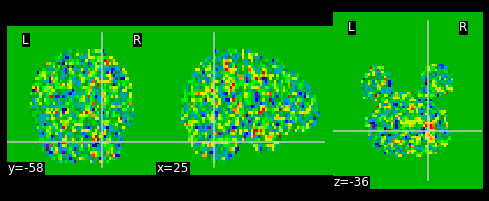

In [58]:
#Let's visualize our result! Doesn't really tell us much, but that's the data we're using for analysis!
nplot.plot_epi(clean_img.slicer[:,:,:,50])

***

### Done!

Hopefully by now you've learned what confound regression is, and how to perform it in nilearn using 2 different methods. We'd like to note that there are many more methods to perform confound regression (simultaneous signal extraction + confound regression for example) but all those methods fundamentally rely on what you've done here. 

In addition, performing confound regression on *functional volumes*, is also not the only way to do data cleaning. More modern methods involve applying confound regression on *functional surfaces*, however, those methods are too advanced for an introductory course to functional data analysis and involve tools outside of python. 

If you're interested in surface-based analysis we recommend that you check out the following sources:

1. https://edickie.github.io/ciftify/#/
2. https://www.humanconnectome.org/software/connectome-workbench
3. [The minimal preprocessing pipelines for the Human Connectome Project](https://www.ncbi.nlm.nih.gov/pubmed/23668970)

***

The section below is **optional** and is a more advanced dive into the underlying mechanics of how `nilearn.clean_img` works:

#### (OPTIONAL) Method 2: Using <code>nilearn.signal.clean</code>


The arguments to this function are almost identical to <code>nilearn.image.clean_img</code>: 

<code>nilearn.signal.clean(signals,confounds,[low_pass],[high_pass],[t_r],[detrend],[standardize]</code> 

The only difference being:

- <code>signals</code>: The resting state signals matrix
- no <code>mask_img</code> argument exists, we'll have to pick which voxels to apply confound regression to ourselves!

In [ ]:
#Load in nilearn.signal
from nilearn import signal as sgl

#### Step 1: Set up our data signals matrix
Recall our data is a 4D array, with the fourth dimension represented as time and the other 3 dimensions representing the (x,y,z) coordinate of a particular voxel. We want to convert this to a matrix represented as the following:

$$
\left.\left( 
\vphantom{ \begin{array}{c} 1 \\ 1 \\1 \\1 \\1 \end{array} }
\smash{ \underbrace{
                    \begin{array}{cccccc} 
                    a_1 & b_1 & c_1 & \cdots & x_1 & \\
                    a_2 & b_2 & c_2 & \cdots & x_2 &\\
                    a_3 & b_3 & c_3 & \cdots & x_3 &\\
                    \vdots & \vdots & \vdots &\cdots & \vdots &\\
                    a_T & b_T & c_T & \cdots & x_T & 
                    \end{array}
                   }_{x*y*z \text{ voxels }}
      }
\right)
\right\}\,T\text{ number of frames}
$$

<br><br>
- The **number of columns represents the total number of voxels (x\*y\*z)**, each column being a single voxel
- The **number of rows represents the number of timepoints**

So we need to *reshape* our data to match this:

In [ ]:
#First we pull out our data as a numpy arrays
func_data = func_img.get_data()

#Then we get x,y,z dimensions
x,y,z,t = func_data.shape

#Then we get total number of voxels across all frames, x*y*z
total_voxels = x*y*z

#Then we reshape to the correct size, note that matrix is flipped on its side
#Where the number of rows matches the number of voxels instead of time-series
signals = func_data.reshape([total_voxels,t])
print(signals.shape)

In [ ]:
#Now we flip it over (switch columns and rows) 
signals = signals.transpose() 
print(signals.shape) 

#### Step 2: Masking our signals matrix (Optional)

Using this <code>signals</code> matrix will work, but we'll also be cleaning *background/non-brain* voxels which may slow down our cleaning if we're cleaning hundreds (or *thousands* in the case of HCP) of images. 

To speed up the process we should only apply cleaning to the *subset of voxels that belong to the brain*. We can do this by masking out which voxels to apply cleaning to. This is equivalent to using <code>mask_img</code> in **Method 1** except we'll be doing this manually - it'll be slightly more complicated!.

To apply the mask to our <code>signals</code>, we want our mask to be in a similar format to our <code>signals</code>

In [ ]:
#Load in mask image
mask_img = nimg.load_img(mask_file)

#Pull out data matrix
mask_data = mask_img.get_data()

#Get dimensions of mask image
mx, my, mz = mask_data.shape

#Reshape the data so that each column corresponds to a voxel
flattened_mask = mask_data.reshape([mx*my*mz])
flattened_mask.shape

The end result is a 1-dimensional array where each element corresponds to a voxel. Any element that is equal to 0 corresponds to a background voxel and any element corresponding to a brain voxel is equal to 1. 
To select which voxels to clean we'll find all the indices where <code>flattened_mask</code> equals 1

In [ ]:
#Get the voxel indices (corresponding to column #s in our signals) that are non-zero (brain voxels) 
brain_voxels = flattened_mask.nonzero()[0] #nonzero() returns a tuple, we just want the array
print(brain_voxels)

#### Step 3: Cleaning our data
First we'll set up our filtering variables

In [ ]:
#Set up variables for confound regression
low_pass = 0.08 
high_pass = 0.009
rep_time= 2

Applying the actual cleaning once our data is set up will be very similar to <code>nilearn.image.clean_img</code> in form. The major difference will be that to mask our data we'll pick which indices to apply <code>nilearn.signal.clean</code> to using <code>brain_voxels</code>. 

*** 

In practice we'll do the following: 
1. Create an matrix of zeros matching our <code>signals</code>, we'll call it <code>cleaned_signals</code>
2. In the voxels (columns) corresponding to <code>brain_voxels</code> write in the cleaned time-series

Specifically, step 2 will be accomplished using the following:

<code>cleaned_signals[:,brain_voxels] = nilearn.signal.clean(signals[:,brain_voxels],...)</code> 

Notice, <code>signals[:,brain_voxels]</code>, this does two things: 
1. Select all rows - **rows correspond to frames and we want all frames**
2. Select the columns using <code>brain_voxels</code>. Remember **columns represent voxels, and <code>brain_voxels</code> corresponds to brain voxels**. 

Then <code>cleaned_signals[:,brain_voxels]</code> will select which voxels to write our cleaned time-series into. Notice that doing this sets our background voxels to 0. 

In [ ]:
#First create a matrix of zeroes that matches our signals matrix
cleaned_signals = np.zeros_like(signals)

#Apply only to brain voxels
cleaned_signals[:,brain_voxels] = sgl.clean(signals[:,brain_voxels],confounds=confounds_matrix,
                           detrend=True,standardize=True,
                           low_pass=low_pass,high_pass=high_pass,
                          t_r=rep_time)

In [ ]:
#Now we can reconstruct our volume, just perform operations in reverse
#Step 1: Flip it back
cleaned_signals = cleaned_signals.transpose() 

#Step 2: Reshape it back into a 4D time-series
cleaned_brain = cleaned_signals.reshape([x,y,z,t])

In [ ]:
#The cleaned image generated from nilearn.signal.clean
signals_cleaned_img = nib.Nifti1Image(cleaned_brain,np.eye(4))

In [ ]:
nplot.plot_epi(signals_cleaned_img.slicer[:,:,:,50])

Let's compare this to <code>cleaned_img</code> which is what we generated using <code>nilearn.image.clean_img</code>. They should be identical

In [ ]:
nplot.plot_epi(clean_img.slicer[:,:,:,50])